# Noisy DQN, Deep Q Learning

In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3 # for soft update of target parameters
LR = 5e-4
PRINT_EVERY = 100
UPDATE_EVERY = 4

## Set Environment

In [7]:
ENV_NAME = 'MountainCar-v0'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

[2020-02-06 12:30:08,204] Making new env: MountainCar-v0
/Users/angga.muhammad/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [8]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(2,)
Action space Discrete(3)


## Build Noisy Network

In [9]:
class NoisyNet(nn.Module):
    
    def __init__(self, input_features, output_features, sigma_init=0.4, train_mode=True):
        
        super(NoisyNet, self).__init__()
        
        self.input_features = input_features
        self.output_features = output_features
        self.sigma_init = sigma_init
        self.train_mode = train_mode
        
        self.mu_weight = nn.Parameter(torch.FloatTensor(output_features, input_features))
        self.sigma_weight = nn.Parameter(torch.FloatTensor(output_features, input_features))
        self.register_buffer('epsilon_weight', torch.FloatTensor(output_features, input_features))
        
        self.mu_bias = nn.Parameter(torch.FloatTensor(output_features))
        self.sigma_bias = nn.Parameter(torch.FloatTensor(output_features))
        self.register_buffer('epsilon_bias', torch.FloatTensor(output_features))
        
        self.reset_parameters()
        self.reset_noise()
        
    def reset_parameters(self):
        
        mu_range = 1 / math.sqrt(self.mu_weight.size(1))
        
        self.mu_weight.data.uniform_(-mu_range, mu_range)
        self.sigma_weight.data.fill_(self.sigma_init / math.sqrt(self.sigma_weight.size(1)))
        
        self.mu_bias.data.uniform_(-mu_range, mu_range)
        self.sigma_bias.data.fill_(self.sigma_init / math.sqrt(self.sigma_bias.size(0)))
    
    def reset_noise(self):
        
        input_size = self.input_features
        epsilon_input = torch.randn(input_size)
        epsilon_input = epsilon_input.sign().mul(epsilon_input.abs().sqrt())
        
        output_size = self.output_features
        epsilon_output = torch.randn(output_size)
        epsilon_output = epsilon_output.sign().mul(epsilon_output.abs().sqrt())
        
        self.epsilon_weight.copy_(epsilon_output.ger(epsilon_input))
        self.epsilon_bias.copy_(epsilon_output)
        
    def forward(self, x):
        
        if self.train_mode:
            weight = self.mu_weight + self.sigma_weight.mul(autograd.Variable(self.epsilon_weight))
            bias = self.mu_bias + self.sigma_bias.mul(autograd.Variable(self.epsilon_bias))
        else:
            weight = self.mu_weight
            bias = self.mu_bias
            
        return F.linear(x, weight, bias)

## Build DQN Architecture

In [10]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, state_size, action_size, seed, fcl_units=64, fc2_units=64):
        """Initialize parameters and build model."""
        
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.fc1_layer = nn.Linear(state_size, fcl_units)
        self.noisy1_layer = NoisyNet(fcl_units, fc2_units)
        self.noisy2_layer = NoisyNet(fc2_units, action_size)
        
    def reset_noise(self):
        self.noisy1_layer.reset_noise()
        self.noisy2_layer.reset_noise()
        
    def forward(self, state):
        """Build a network that maps state into action values."""
        
        state = F.relu(self.fc1_layer(state))
        state = F.relu(self.noisy1_layer(state))
        Qsa = self.noisy2_layer(state)
        
        return Qsa        

## Set Replay Buffer

In [11]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object."""
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define [Noisy DQN](https://arxiv.org/pdf/1706.10295.pdf) Agent

In [12]:
class Noisy_DQNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an agent object."""
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.dqn_net = DQN(state_size, action_size, seed).to(device)
        self.target_net = DQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.dqn_net.parameters(), lr=LR)
        
        # Replay Buffer
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
            
    def act(self, state):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
        self.dqn_net.train()
        
        return np.argmax(action_values.cpu().data.numpy())
        
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
    
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get index of maximum value for next state
        Qsa_next = self.dqn_net(next_states).detach()
        _, action_max = Qsa_next.max(1)

        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states).detach().gather(1, action_max.unsqueeze(1))
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_target, Q_expected)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # reset noise for both DQN and target networks
        self.dqn_net.reset_noise()
        self.target_net.reset_noise()
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update target network parameters."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)

In [13]:
agent = Noisy_DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=90)

In [14]:
# watch an untrained agent
state = env.reset()
for time_step in range(200):
    
    # select an action
    action = agent.act(state)
    env.render()
    
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

## Train The Agent

In [15]:
def train_agent(num_episodes, max_time=1000):
    """Train DQN agent."""
    
    scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        score = 0
        for time_step in range(max_time):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= -200.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            torch.save(agent.dqn_net.state_dict(), f'./agents/Noisy_DQN_without_EGP_{ENV_NAME}.pth')
            
    print('Training completed.')
    return scores

In [16]:
scores = train_agent(num_episodes=1000, max_time=1000)

Episode: 100, Average Score: -731.09
Episode: 200, Average Score: -678.01
Episode: 300, Average Score: -457.17
Episode: 400, Average Score: -295.77
Episode: 500, Average Score: -286.44
Episode: 600, Average Score: -304.11
Episode: 700, Average Score: -326.18
Episode: 800, Average Score: -236.32
Episode: 881, Average Score: -199.37
Environment solved in 781 episodes! Average Score: -199.37
Episode: 882, Average Score: -198.98
Environment solved in 782 episodes! Average Score: -198.98
Episode: 883, Average Score: -197.23
Environment solved in 783 episodes! Average Score: -197.23
Episode: 884, Average Score: -197.23
Environment solved in 784 episodes! Average Score: -197.23
Episode: 885, Average Score: -196.69
Environment solved in 785 episodes! Average Score: -196.69
Episode: 886, Average Score: -196.81
Environment solved in 786 episodes! Average Score: -196.81
Episode: 887, Average Score: -196.08
Environment solved in 787 episodes! Average Score: -196.08
Episode: 888, Average Score: -19

Episode: 965, Average Score: -170.27
Environment solved in 865 episodes! Average Score: -170.27
Episode: 966, Average Score: -169.17
Environment solved in 866 episodes! Average Score: -169.17
Episode: 967, Average Score: -168.97
Environment solved in 867 episodes! Average Score: -168.97
Episode: 968, Average Score: -168.05
Environment solved in 868 episodes! Average Score: -168.05
Episode: 969, Average Score: -169.87
Environment solved in 869 episodes! Average Score: -169.87
Episode: 970, Average Score: -169.39
Environment solved in 870 episodes! Average Score: -169.39
Episode: 971, Average Score: -168.32
Environment solved in 871 episodes! Average Score: -168.32
Episode: 972, Average Score: -166.65
Environment solved in 872 episodes! Average Score: -166.65
Episode: 973, Average Score: -167.70
Environment solved in 873 episodes! Average Score: -167.70
Episode: 974, Average Score: -168.27
Environment solved in 874 episodes! Average Score: -168.27
Episode: 975, Average Score: -168.78
Env

## Evaluate The Agent

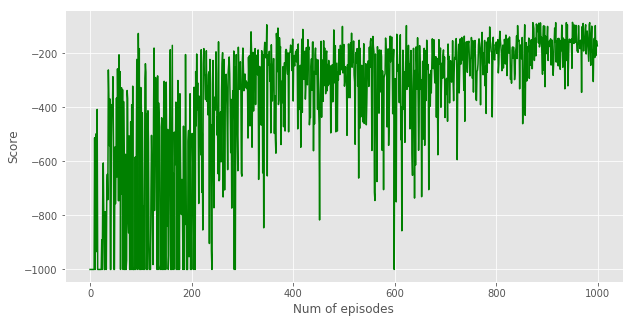

In [17]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_agent_evaluation_without_EGP')
plt.show()

## 🎬 Watch The Smart Agent

In [18]:
# load the weights of smart agent
agent.dqn_net.load_state_dict(torch.load(f'./agents/Noisy_DQN_without_EGP_{ENV_NAME}.pth'));

In [19]:
num_episodes = 5

for i_episode in range(1, num_episodes+1):
    
    state = env.reset()
    rewards = []
    for time_step in range(200):
        
        env.render() # render the screen
        
        action = policy.act(state) # select an action
        next_state, reward, done, _ = env.step(action)
        
        state = next_state
        rewards.append(reward)
        if done:
            break
            
    print(f'\rEpisode: {i_episode}, Average Score: {sum(rewards):.2f}')

env.close()

---